# Class Overview
<img src="PDF_slides/class_overview.png"  width="500">


___
# Agenda
 - Numerical Optimization Techniques
  - Types of Optimization
  - Programming the Optimization
 - **Whirlwind Lecture Alert**
  - Entire classes cover these concepts in expanded form
  - But we can cover them in one lecture to get a good intuition!
  - And then you can look over this even more for better understanding.
  - If you feel confused after this lecture, that's okay. These are not easy the first time you see them. Keep going, you got this.
  
<img src="PDF_slides/dont-be-nervous-you-got-this-meme.jpg"  width="300">


    
___

# Last Time

|Description| Equations, Derivations, Hessian Calculations, and Miscellaneous|
|-----------|--------|
| Sigmoid Definition | $$ p(y^{(i)}=1\text{ | }\mathbf{x}^{(i)},\mathbf{w})=\frac{1}{1+\exp{(-\mathbf{w}^T \mathbf{x}^{(i)}})}$$ |
| Log Likelihood | $$ l(\mathbf{w}) = \sum_i \left( y^{(i)} \ln [g(\mathbf{w}^T \mathbf{x}^{(i)})] + (1-y^{(i)}) (\ln [1 - g(\mathbf{w}^T \mathbf{x}^{(i)})])  \right)  $$ |
| Vectorized Gradient | $$gradient = \nabla l(\mathbf{w}) =\frac{1}{M}\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}$$ |
| Regularization | $$ \mathbf{w} \leftarrow \mathbf{w} + \eta \left[\underbrace{\nabla l(\mathbf{w})_{old}}_{\text{old gradient}} - C \cdot 2\mathbf{w} \right]$$|

___

In [2]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split

ds = load_iris()
X = ds.data
y = (ds.target>1).astype(int) # make problem binary
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size=0.2)


In [3]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

blr = BinaryLogisticRegression(eta=0.1,iterations=50,C=0.001)

blr.fit(X_train,y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.20089197]
 [-0.4670883 ]
 [-0.51457683]
 [ 0.7630656 ]
 [ 0.5081168 ]]
Accuracy of:  1.0
CPU times: user 5.03 ms, sys: 2.84 ms, total: 7.87 ms
Wall time: 7.99 ms



<img src="PDF_slides/BtJXjJcCAAE7QOB.jpg"  width="300">

# More Advanced  Optimization for Machine Learning

## Problem One: finding the right eta
From previous notebooks, we know that the logistic regression update equation is given by:

$$ \underbrace{w_j}_{\text{new value}} \leftarrow \underbrace{w_j}_{\text{old value}} + \eta \underbrace{\left[\left(\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))x^{(i)}_j\right) - C \cdot 2w_j \right]}_{\nabla l(w)}$$

Which can be made into more generic notation by denoting the objective function as $l(\mathbf{w})$ and the gradient calculation as $\nabla$:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \nabla l(\mathbf{w})$$

One problem is that we still need to set the value of $\eta$, which can drastically change the performance of the optimization algorithm. If $\eta$ is too large, the algorithm might be unstable. If $\eta$ is too small, it might take a long time (i.e., many iterations) to converge.


<img src="PDF_slides/batch.gif"  width="400">

## Optimizing Logistic Regression via Line Search
We can solve this issue by performing a line search for the best value of $\eta$ along the direction of the gradient.

$$ \mathbf{w} \leftarrow \mathbf{w} + \underbrace{\eta}_{\text{best step?}} \nabla l(\mathbf{w}) $$

$$ \eta \leftarrow \arg\max_\eta l(\mathbf{w}+\eta\cdot\nabla l(\mathbf{w})) $$

<img src="PDF_slides/line_search copy.gif"  width="400">


We can also use the golden section search to find the best value of the line we are interested in searching along, such that objective function calculations are minimized:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Diagram_of_a_golden_section_search.jpg" width="400">

In [4]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    def __init__(self, line_iters=0.0, **kwds):        
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
    
    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + C*sum(wnew[1:]**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization is in opposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                
            

lslr = LineSearchLogisticRegression(eta=1.0,
                                    iterations=6, 
                                    line_iters=8, 
                                    C=0.001)

lslr.fit(X_train,y_train)

yhat = lslr.predict(X_test)
print(lslr)
print('Accuracy of: ',accuracy_score(y_test,yhat))         

Binary Logistic Regression Object with coefficients:
[[-1.00164139]
 [-2.35775886]
 [-3.12998561]
 [ 4.18857275]
 [ 2.4959703 ]]
Accuracy of:  1.0
CPU times: user 11 ms, sys: 3.74 ms, total: 14.8 ms
Wall time: 13 ms


This performs well, but was not too much faster than previously (this is because $\eta$ was chosen well in the initial example). 
___

# Self Test
How much computation (i.e., how many multiplies) are required for calculating the gradient of:
$$ \left( \frac{1}{M}\left[\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\cdot\mathbf{x}^{(i)}))\cdot \mathbf{x}^{(i)}\right] - 2C\cdot \mathbf{w}\right) $$

Where $M$ is the number of instance and $N$ is the number of elements in $\mathbf{w}$.

- A: $ M\cdot N+1$
- B: $ 2\cdot M \cdot N+ N$
- C: $ 2N $ 
- D: $ 2N-M$ 
_____

# Stochastic Gradient Descent (Mini-batching)
Sometimes the gradient calculation is too computational:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta\left( \frac{1}{M}\left[\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}\right] - 2C\cdot \mathbf{w}\right) $$

Instead, we can approximate the gradient using a smaller number of instances (perhaps even just one instance), this is called stochastic gradient descent (SGD) because the steps can appear somewhat random.

For a single instance, this becomes: 

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \underbrace{\left((y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}-2C\cdot \mathbf{w}\right)}_{\text{approx. gradient}} \text{,   where   } i\in M$$

<img src="PDF_slides/SGD.gif"  width="400">

For a small batch (mini-batch) of samples, this becomes:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta\left( \frac{1}{M_{sub}}\left[\sum_{i\in M_{sub}} (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}\right] - 2C\cdot \mathbf{w}\right) $$

Let's code up the SGD example.

In [5]:
%%time

class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        
        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)
        
        ydiff = y[idxs]-self.predict_proba(X[idxs],add_bias=False).ravel() # get y difference (now scalar)
        gradient = np.mean(X[idxs] * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    
slr = StochasticLogisticRegression(eta=0.01, iterations=100, C=0.001) # take a lot more steps!!

slr.fit(X_train,y_train)

yhat = slr.predict(X_test)
print(slr)
print('Accuracy of: ',accuracy_score(y_test,yhat))      

Binary Logistic Regression Object with coefficients:
[[-0.06384544]
 [-0.16011584]
 [-0.19443504]
 [ 0.24273753]
 [ 0.14941267]]
Accuracy of:  0.7666666666666667
CPU times: user 4.66 ms, sys: 1.75 ms, total: 6.41 ms
Wall time: 5.38 ms


___



<img src="PDF_slides/hessian_second.jpg"  width="300">




# Optimizing with Second Order Derivatives
First, let's look at the one dimensional case when we have a function $l(w)$ where w is a scalar. The optimal value of w is given by:

$$ w_{optimal} \leftarrow w_{start} - \underbrace{[\frac{\partial^2}{\partial w}l(w_{start})]^{-1}}_{\text{inverse 2nd deriv}}\underbrace{\frac{\partial}{\partial w}l(w_{start})}_{\text{derivative}}  $$

Note that if $l(w)$ is a quadratic function, this solution converges in a single step!


**Aside: an example with the second derivative:**
- Say $l(w)=2w^2+4w+5$, and we want to minimize the function. We have that:
- $\frac{\partial}{\partial w}l(w)=4w+4$
- $\frac{\partial^2}{\partial w}l(w)=4$
- Therefore, if we choose $w_{start}=0$, we have:
- $\frac{\partial}{\partial w}l(0)=4$
- $\frac{\partial^2}{\partial w}l(0)=4$ 
- So the update becomes
- $w \leftarrow w_{start} - \frac{1}{4}4 = -1$
- The solution is found in one step. This works for any initial value of $w_{start}$. Let's verify that the solution worked graphically.

Text(-1, 2.5, '$\\leftarrow$found minimum')

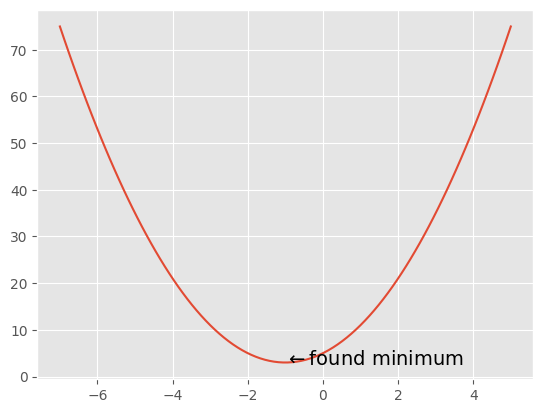

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

w = np.linspace(-7,5,100)
l = 2*w**2+4*w+5
plt.plot(w,l)
plt.text(-1,2.5,'$\leftarrow$found minimum',fontsize=14)

___


# Newton's Update Method
<img src="PDF_slides/newton.png"  width="600">

But how do we translate this over to objective funtions with more than one variable? We need a second derivative of a multivariate equation... enter, the hessian. Our new update is defined by Newton's method:

$$ w \leftarrow w - \underbrace{[\frac{\partial^2}{\partial w}l(w)]^{-1}}_{\text{inverse 2nd deriv}}\underbrace{\frac{\partial}{\partial w}l(w)}_{\text{derivative}}  $$

such that, in multiple dimensions we can approximate the update as:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\mathbf{H}(\mathbf{w})^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$

where the Hessian is defined as follows for any multivariate equation $l(\mathbf{w})$:
$$ \nabla^2 l(\mathbf{w}) = \mathbf{H}(\mathbf{w})   $$

$$  \mathbf{H}(\mathbf{w}) =  \begin{bmatrix}
        \frac{\partial^2}{\partial w_1}l(\mathbf{w}), &  \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_2}l(\mathbf{w}), & \ldots     & \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_N}l(\mathbf{w})  \\
        \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_1}l(\mathbf{w}),  & \frac{\partial^2}{\partial w_2}l(\mathbf{w}), &  \ldots     & \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_N}l(\mathbf{w})  \\
        &  \vdots &\\
        \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_1}l(\mathbf{w}),  & \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_2}l(\mathbf{w}), &  \ldots     & \frac{\partial^2}{\partial w_N}l(\mathbf{w}) \\
     \end{bmatrix}
$$



____
For logistic regression, we can calculate the formula for the $j^{th}$ and $k^{th}$ element of the Hessian as follows:

$$ \mathbf{H}_{j,k}(\mathbf{w}) = \frac{\partial}{\partial w_k} \underbrace{\frac{\partial}{\partial w_j}l(\mathbf{w})}_{\text{first derivative}} $$

Since this second partial derivative is identical regardless of the ordering of derivatives taken, the Hessian is also symmetric about the diagonal:

<img src="PDF_slides/spider_hessian.png"  width="400">


But we already know the result of the $j^{th}$ partial derivative from our calculation of $\nabla l(\mathbf{w})$: 

$$ \frac{\partial}{\partial w_j}l(\mathbf{w}) = \sum_i \left(y^{(i)}-g(\mathbf{w}^T\cdot\mathbf{x}^{(i)})\right)x_j^{(i)} $$

So we can plug this back into the equation to get:

$$ 
\begin{split}
\mathbf{H}_{j,k}(\mathbf{w}) & = \frac{\partial}{\partial w_k}\sum_i \left(y^{(i)}-g(\mathbf{w}^T\cdot\mathbf{x}^{(i)})\right)x_j^{(i)} \\
 & = \underbrace{\sum_i \frac{\partial}{\partial w_k} y^{(i)}x_j^{(i)}}_{\text{no dependence on }k\text{, zero}} -\sum_i \frac{\partial}{\partial w_k}g(\mathbf{w}^T\cdot\mathbf{x}^{(i)})x_j^{(i)} \\
 & = -\sum_i x_j^{(i)}\underbrace{\frac{\partial}{\partial w_k}g(\mathbf{w}^T\cdot\mathbf{x}^{(i)})}_{\text{already know this as }g(1-g)x_k} \\
 & =  -\sum_{i=1}^M \left[g(\mathbf{w}^T\mathbf{x}^{(i)})[1-g(\mathbf{w}^T\mathbf{x}^{(i)})]\right]\cdot{x_k}^{(i)}{x_j}^{(i)} \\
\end{split}
$$





Therefore the Hessian for logistic regression becomes (adding in the regularization term also):
$$ \mathbf{H}_{j,k}(\mathbf{w}) =\left( -\sum_{i=1}^M \underbrace{\left[g(\mathbf{w}^T\mathbf{x}^{(i)})[1-g(\mathbf{w}^T\mathbf{x}^{(i)})]\right]}_{\text{scalar value for each instance}}\cdot\underbrace{{x_k}^{(i)}{x_j}^{(i)}}_{i^{th}\text{ instance elements}} \right) + \underbrace{2\cdot C}_{\text{regularization}}  $$


This equation can be calcuated in a for loop, for each $j,k$ element in the Hessian and for each instance in the dataset, but this would be **slow** in python. To vectorize this operation, we need to have each operation be linear algebra, so that it can be run efficiently with numpy. 
____
## Calculating the Hessian for Logistic Regression using Linear Algebra
First notice that the sum of each terms ${x_k}^{(i)}{x_j}^{(i)}$ that forms a matrix can be calculated as follows:

$$    
\begin{bmatrix}
        \sum_{i=1}^M {x_1}^{(i)}{x_1}^{(i)}, & \sum_{i=1}^M {x_1}^{(i)}{x_2}^{(i)}, & \ldots     &  \sum_{i=1}^M {x_1}^{(i)}{x_N}^{(i)}, \\
        \sum_{i=1}^M {x_2}^{(i)}{x_1}^{(i)}, & \sum_{i=1}^M {x_2}^{(i)}{x_2}^{(i)}, & \ldots     &  \sum_{i=1}^M {x_2}^{(i)}{x_N}^{(i)}, \\
        &  \vdots & \\
        \sum_{i=1}^M {x_N}^{(i)}{x_1}^{(i)}, & \sum_{i=1}^M {x_N}^{(i)}{x_2}^{(i)}, & \ldots     &  \sum_{i=1}^M {x_N}^{(i)}{x_N}^{(i)} \\ \\
\end{bmatrix}   
%
= \mathbf{X}^T \cdot\mathbf{X} = \mathbf{X}^T \cdot\mathbf{I} \cdot\mathbf{X}
$$

where $\mathbf{I}$ is the identity matrix of size $M\text{x}M$. This can be seen in the following exploded view of the matrix operations: 

$$ \mathbf{X}^T \cdot\mathbf{I} \cdot\mathbf{X}=
\begin{bmatrix}
        \uparrow &    \uparrow    &    & \uparrow  \\
        \mathbf{x}^{(1)} &  \mathbf{x}^{(2)} & \ldots   & \mathbf{x}^{(M)}  \\
        \downarrow &    \downarrow    &   & \downarrow  \\
\end{bmatrix}_{(N\times M)}
%
\begin{bmatrix}
        1 &  0 & \ldots & 0 \\
        0 &  1 & \ldots & 0 \\
          &  \vdots  & &    \\
        0 &  0 & \ldots & 1 \\
\end{bmatrix}_{(M\times M)}
%
\begin{bmatrix}
        \leftarrow &  \mathbf{x}^{(1)}      & \rightarrow  \\
        \leftarrow &  \mathbf{x}^{(2)}      & \rightarrow  \\
        &  \vdots &\\
        \leftarrow &  \mathbf{x}^{(M)}      & \rightarrow  \\
\end{bmatrix}_{(M\times N)}
%
$$

With this equation in mind, we can revisit the calcualtion of the Hessian and use matrix operations to define the needed multiplication in an exploded view of the operations:
$$ \mathbf{H}[\mathbf{w}]= $$
$$ 
\begin{bmatrix}
        \uparrow &    \uparrow    &    & \uparrow  \\
        \mathbf{x}^{(1)} &  \mathbf{x}^{(2)} & \ldots   & \mathbf{x}^{(M)}  \\
        \downarrow &    \downarrow    &   & \downarrow  \\
\end{bmatrix}
%
\begin{bmatrix}
        g(\mathbf{w}^T\mathbf{x}^{(1)})[1-g(\mathbf{w}^T\mathbf{x}^{(1)})] & \ldots & 0 \\
          &  \vdots   &    \\
        0  & \ldots & g(\mathbf{w}^T\mathbf{x}^{(M)})[1-g(\mathbf{w}^T\mathbf{x}^{(M)})] \\
\end{bmatrix}
%
\begin{bmatrix}
        \leftarrow &  \mathbf{x}^{(1)}      & \rightarrow  \\
        \leftarrow &  \mathbf{x}^{(2)}      & \rightarrow  \\
        &  \vdots &\\
        \leftarrow &  \mathbf{x}^{(M)}      & \rightarrow  \\
\end{bmatrix}
%
$$

___
Or, more succinctly as follows (adding in the regularization term as well):

$$ \mathbf{H}[\mathbf{w}] =  \mathbf{X}^T \cdot \text{diag}\left[g(\mathbf{X}\cdot\mathbf{w})\odot(1-g(\mathbf{X}\cdot\mathbf{w}))\right]\cdot \mathbf{X} -2C$$

___

Now we can place the Hessian derivation into the Newton Update Equation, like this:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\mathbf{H}[\mathbf{w}]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$

Adding in the exact equations for the Hessian and gradient, we can finally get:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\left[\mathbf{X}^T \cdot \text{diag}\left[g(\mathbf{X}\cdot\mathbf{w})\odot(1-g(\mathbf{X}\cdot\mathbf{w}))\right] \cdot \mathbf{X} -2C \right]^{-1} }_{\text{inverse Hessian}} \cdot \underbrace{\mathbf{X}\odot y_{diff}}_{\text{gradient}}$$


You can see the full derivation of the Hessian in my hand written notes here also:
- https://raw.githubusercontent.com/eclarson/MachineLearningNotebooks/master/PDF_Slides/HessianCalculation.pdf



So let's code this up using numpy:

In [7]:
%%time

# note to future (2024) Eric: call this get_dirtection, instead of gradient

from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
       
hlr = HessianBinaryLogisticRegression(eta=1.0,
                                      iterations=4,
                                      C=0.001) # note that we need only a few iterations here

hlr.fit(X_train,y_train)
yhat = hlr.predict(X_test)
print(hlr)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-10.49245761]
 [ -1.13444874]
 [ -1.09525527]
 [  2.47576674]
 [  5.15314995]]
Accuracy of:  1.0
CPU times: user 2.02 ms, sys: 3.8 ms, total: 5.82 ms
Wall time: 4.88 ms


___
### Can we still do better? Problems With the Hessian:
Quadratic isn’t always a great assumption:
 - highly dependent on starting point
  - jumps can get really random!
 - near saddle points, inverse hessian is unstable
 - hessian not always invertible… or invertible with enough numerical precision
 
The Hessian can sometimes be ill formed for these problems and can also be highly computational. Thus, we prefer to approximate the Hessian, and approximate its inverse to better control the steps we make and directions we use.  

<img src="PDF_slides/gru_hessian.jpg"  width="400">

____

# Quasi-Newton Methods
In general:
 - Approximate the Hessian with something numerically sound and efficiently invertible 
 - Back off to gradient descent when the approximate hessian is not stable
 - Try to create an approximation with as many properties of the Hessian as possible, like being symmetric and positive semi-definite
 - A popular approach: Rank One Hessian Approximation
 - An even more popular appraoch: Rank Two, with Broyden-Fletcher-Goldfarb-Shanno (BFGS)


### Rank One Hessian Approximation 
Let's work our way up to using BFGS by first looking at one quasi-newton method, the rank one Hessian approximation. **Note, I only want you to get an intuition for this process. There is no requirenemtn to understand the derivation completely.**
Essentially, we want to update the Hessian with an approximation that is easily invertible and based on stable gradient calculations. We can define the approximate Hessian for each iteration of the optimization, $\mathbf{H}_k$. That is, we will be optimizing $\mathbf{w}$ over a number of iterations, $k$. We refer to the evolving vector as $\mathbf{w}_{k}$. Each time we update this quantity, we can also update our Hessian approximation, $\mathbf{H}_k$.

**To start as simple as possible, we will assume the Hessian can be approximated with one vector, often called the rank one approximation.** Let's start off with a few other assumptions. We wil develop some equations that characterize a family of solutions. Within this rank one family, we will only give one popular solution. After this, we will then motivate an example in the rank two family of solutions. 

___
#### Step One: Use the secant equation
One property of the hessian is called the Secant equation, which relates the change in input to the change in the derivative. The Secant Equation (exact for quadratic functions) is:
$$ \underbrace{\mathbf{H}_{k+1}}_{\text{approx. Hessian}} \cdot\underbrace{(\mathbf{w}_{k+1} - \mathbf{w}_k)}_{\text{Change in }w} = \underbrace{\nabla l(\mathbf{w}_{k+1}) - \nabla l(\mathbf{w}_k)}_{\text{Change in gradient}}$$

or, using intermediate variables for the differences: 
$$ \mathbf{H}_{k+1} \mathbf{s}_k =  \mathbf{v}_k $$

where $ \mathbf{s} = (\mathbf{w}_{k+1} - \mathbf{w}_k) $ and $ \mathbf{v} = (\nabla l(\mathbf{w}_{k+1}) - \nabla l(\mathbf{w}_k)) $, the difference in the gradient. If we enforce this relationship, we can solve for the hessian by calculating $\mathbf{s}$ and $\mathbf{v}$. We can also add some extra constraints since we want the Hessian to be symmetric and the next guess to be not "too far away" from our current guess (for stable optimization). Practically, this means that the new Hessian guess will be an average between the old value and our new guess, which is called momentum when performing optimization.

___

#### Step Two: Use the rank one update assumption
For optimizing, we would like to be able to update the Hessian at $\mathbf{w}_{k+1}$ from our previous guess, $\mathbf{H}_k$ at $\mathbf{w}_{k}$, and have the update be easy to calculate. Therefore, we can choose the update of the Hessian to be approximated by the rank one update (one vector). Since the Hessian is the second partial derivative, a starting approximation might be the gradient difference we already defined such that  $\mathbf{H} \approx \mathbf{v}\cdot\mathbf{v}^T$ which would form a matrix of the differences of each partial deriviative in the gradient. In practice, we need a vector that is slightly less constrained, such that    
$$ \mathbf{H}_{k+1}=\mathbf{H}_k+\alpha_k\mathbf{u}\cdot\mathbf{u}^T $$
Where $\mathbf{u}$ and $\alpha_k$ can be anything we want. This gives us a general form for the approximation, but has too many solutions to be of practical use. So, let's combine this form with our secant equation from the previous step. 

Substituting back into the secant formula:
$$ \mathbf{H}_{k+1} \mathbf{s}_k =  \mathbf{v}_k \qquad\rightarrow\qquad (\mathbf{H}_k +\alpha_k\mathbf{u}_k\cdot\mathbf{u}_k^T)\mathbf{s}_{k} = \mathbf{v}_{k} $$


Many solutions exist for this and they are referred to as a family of rank one Hessian approximations. One solution of this equation is to use the difference in our secant approximation. The intuition here is that we want to update the Hessian approximation more when the error from the secant equation is large. That is, if the Hessian approximation exactly matched the secant equation, its a good update and $\alpha_k$ should be large. If the secant equation was poor, then we should not update our Hessian approximation too much, and $\alpha_k$ should be smaller.   For example we can choose the following:
$$ \mathbf{u}_k=\mathbf{v}_{k}-\mathbf{H}_k \mathbf{s}_{k} \qquad\text{   and   } \qquad\alpha_k=\frac{1}{(\mathbf{v}_{k}-\mathbf{H}_k \mathbf{s}_{k})\mathbf{s}_{k}}=\frac{1}{\mathbf{u}_{k}^T\mathbf{s}_{k}}$$

___
#### Step Three: Combine secant equation with rank one update for iterative solution
and combining this with our initial $\mathbf{H}_{k+1}$ formula:
$$ \mathbf{H}_{k+1}=\mathbf{H}_k- \frac{\mathbf{u}_k\mathbf{u}_k^T}{\mathbf{u}_k^T\mathbf{s}_{k}} $$

This gives an update for the Hessian, which we can use in our optimization formula. Recall that we need to define the vectors using the secant equation assumptions, such that $ \mathbf{v}_k $ and $ \mathbf{s}_k $ are the difference in gradients and difference in weights (respectively) as previously defined.

#### Step Four: Use Sherman-Morris to also iterative track the inverse of our rank one approximation
**This final step illustrates the power of this method.** We can now assume that the inverse of the Hessian can be optimized and formulate similar equations for its update, based upon the previous inverse. Therefore, we need the inverse of $(\mathbf{H}_k+\mathbf{v}_k\cdot\mathbf{v}_k^T)^{-1}$, which *"luckily"* has a closed form solution according to the Sherman-Morrison formula:

$$ (\mathbf{A}+\mathbf{a}\cdot\mathbf{a}^T)^{-1} = \mathbf{A}^{-1} - \frac{\mathbf{A}^{-1} \mathbf{a} \cdot\mathbf{a}^T\mathbf{A}^{-1}}{1+\mathbf{a}^T \mathbf{A}^{-1} \mathbf{a}}  $$

We can now substitute $\mathbf{H}_k$ and $\mathbf{v}_k$ to get our inverse Hessian. This equation is the entire reason we first decided to approximate the Hessian using the rank one update equation! It means we can always calculate a stable inverse Hessian. Moreover, since we will always start our initial guess of the Hessian with the identity matrix, we never actually need to perform the inverse operation. Ever. 

___


#### Summary of Rank One Approximation
Now the optimization can be described as a rank one approximation of the Hessian. Placing it all together, we can get the following:


|Description| Equations, Derivations, Hessian Calculations, and Miscellaneous |
|-----------|--------|
| **Definitions with Rank 1 Approximation** |  |
|$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\mathbf{H}[l(\mathbf{w})]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$ |  |
|1. Initial Approx. Hessian for $k=0$ is identity matrix| $$\mathbf{H}_0=\mathbf{I}$$, $$\mathbf{H}_0^{-1}=\mathbf{I}$$|
|2. Find update direction, $\mathbf{p}_k$ | $$ \mathbf{p}_k = -\mathbf{H}_k^{-1} \nabla l(\mathbf{w}_k) $$| 
|3. Update $\mathbf{w}$|$$\mathbf{w}_{k+1}\leftarrow \mathbf{w}_k + \eta \cdot \mathbf{p}_k $$|
|4. Save scaled direction ($\mathbf{w}_{k+1}-\mathbf{w}_k$)| $$\mathbf{s}_k = \mathbf{w}_{k+1}-\mathbf{w}_k = \eta \cdot \mathbf{p}_k $$ |
|5a. Approximate change in derivative | $$\mathbf{v}_k = \nabla l(\mathbf{w}_{k+1}) - \nabla l(\mathbf{w}_k) $$|
| 5b. Define $\mathbf{u}$ from above: | $$\mathbf{u}_k=\mathbf{v}_k-\mathbf{H}_k\mathbf{s}_k$$| 
|6. Redefine approx Hessian update| $$\mathbf{H}_{k+1}=\mathbf{H}_k+\underbrace{\frac{\mathbf{u}_k \mathbf{u}_k^T}{\mathbf{u}_k^T \mathbf{s}_k}}_{\text{approx. Hessian}} $$ |
|7. Approx. Inverse $\mathbf{H}_{k+1}^{-1}$ via Sherman Morris| $$ \mathbf{H}_{k+1}^{-1} = \mathbf{H}_{k}^{-1} - \frac{\mathbf{H}_k^{-1} \mathbf{u}_k \mathbf{u}_k^T\mathbf{H}_k^{-1}}{1+\mathbf{u}_k^T \mathbf{H}_k^{-1} \mathbf{u}_k} $$ |
| 8. Repeat starting at step 2| $$ k = k+1 $$| 




___
### Rank Two Hessian Approximation: BFGS


Although the rank one approximation is a good performer, it can be improved by adding some additional criteria to the Hessian approximation. In this case, we assume that the $\mathbf{H}_k$ needs to also be positive semi-definite, which helps with numerical stability. One of the most popular quasi-Newton methods that does this is known as Broyden-Fletcher-Goldfarb-Shanno (BFGS). 
- https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm 

<img src="PDF_slides/bfgs_meme.png"  width="300">

#### Replace Step two with a higher rank approximation of the Hessian
In this formulation we add an additional vector matrix addition to the update equation that ensure the resulting matrix is positive semidefinite:
$$ \mathbf{H}_{k+1}=\mathbf{H}_k+\alpha_k\mathbf{u}_k\cdot\mathbf{u}_k^T - \beta_k\mathbf{z}_k\cdot\mathbf{z}_k^T$$

The derivation is intuitively similar to the previous rank one approximation. Again, there are many potential solutions, referred to as a family of rank two solutions. However, it becomes easier to obtain simple solutions for $\mathbf{u}$ and $\mathbf{z}$. Intuitively, we simply choose the difference in gradient for $\mathbf{u}$ and we choose the secant equation for $\mathbf{z}$. The BFGS solution takes the following form:
$$ \mathbf{u}_k = \mathbf{v}_k  \qquad \text{    and    }\qquad \mathbf{z}_k=\mathbf{H}_k \mathbf{s}_k  $$

We can again choose $\alpha_k=\frac{1}{\mathbf{u}_{k}^T\mathbf{s}_{k}}$ and choose $\beta_k = \frac{1}{\mathbf{z}_{k}^T\mathbf{s}_{k}}$. 

After substituiting in $\alpha_k$ and $\beta_k$ coefficients, we get the update equation as:
$$  \mathbf{H}_{k+1}=\mathbf{H}_k+\underbrace{\frac{\mathbf{v}_k \mathbf{v}_k^T}{\mathbf{v}_k^T \mathbf{s}_k}}_{\text{previous}} -\underbrace{\frac{\mathbf{H}_k \mathbf{s}_k \mathbf{s}_k^T \mathbf{H}_k}{\mathbf{s}_k^T \mathbf{H}_k \mathbf{s}_k}}_{\text{new}}  $$

Intuitively, this equation updates the Hessian more when the secant equation is approximated well, meaning it is a safer update. That is, when the current Hessian is a good approximation, the difference in $\mathbf{u}_{k}$ and $\mathbf{z}_{k}$ will also be small. When inverted, $\alpha_k$ and $\beta_k$ become large such that Hessian update is mostly from the new calculations. Conversely, if these are not good approximations of the secant equation, we use smaller $\alpha_k$ and $\beta_k$ values. 

The complete formulation can replace steps from the previous rank update as follows:

|Description| Equations, Derivations, Hessian Calculations, and Miscellaneous |
|-----------|--------|
| **Alternative Definitions with Rank 2 (BFGS)** |  |
| 6. Redefine approx Hessian:| $$\mathbf{H}_{k+1}=\mathbf{H}_k+\frac{\mathbf{v}_k \mathbf{v}_k^T}{\mathbf{v}_k^T \mathbf{s}_k} -\frac{\mathbf{H}_k \mathbf{s}_k \mathbf{s}_k^T \mathbf{H}_k}{\mathbf{s}_k^T \mathbf{H}_k \mathbf{s}_k} $$ |
|7. Approximate Inverse $\mathbf{H}_{k+1}^{-1}$ via Sherman Morris:| $$ \mathbf{H}_{k+1}^{-1} = \mathbf{H}_{k}^{-1} + \frac{(\mathbf{s}_k^T \mathbf{v}_k+\mathbf{H}_{k}^{-1})(\mathbf{s}_k \mathbf{s}_k^T)}{(\mathbf{s}_k^T \mathbf{v}_k)^2}-\frac{\mathbf{H}_{k}^{-1} \mathbf{v}_k \mathbf{s}_k^T+\mathbf{s}_k \mathbf{v}_k^T\mathbf{H}_{k}^{-1}}{\mathbf{s}_k^T \mathbf{v}_k} $$|

___
We won't explicitly program the BFGS algorithm--instead we can take advantage of scipy's calculations to do it for us. For using this algorithm, we need to define the objective function and the gradient explicitly for another program to calculate. 

Recall that Logistic regression uses the following objective and gradient functions:

$$ \text{Objective} = l(\mathbf{w}) = \left(\sum_i y^{(i)} \ln g(\mathbf{x}^{(i)}) + (1-y^{(i)})\ln[1-g(\mathbf{x}^{(i)})]\right)  - C \cdot \sum_j w_j^2 $$

and 

$$ \text{Gradient} =\nabla l(\mathbf{w}) =\text{mean}\left( \mathbf{X}\odot \mathbf{y}_{diff} \right)_{columns} - 2\cdot C \cdot \mathbf{w}$$

we can use these calcualtion directly in the already implemented BFGS algorithm.

In [9]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a fair amount of code and understanding, which we haven't setup yet)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world
from numpy import ma
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
bfgslr = BFGSBinaryLogisticRegression(_,iterations=3,C=0.001) # note that we need only a few iterations here

bfgslr.fit(X_train,y_train)
yhat = bfgslr.predict(X_test)
print(bfgslr)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.1936976 ]
 [-0.44984547]
 [-0.58284252]
 [ 0.83413532]
 [ 0.50464717]]
Accuracy of:  0.9666666666666667
CPU times: user 4.44 ms, sys: 5.63 ms, total: 10.1 ms
Wall time: 8 ms


In [ ]:
#str(bfgslr.eta)

### BFGS and Newton's Method for Multiclass Logistic Regression
Now let's add BFGS and the actual Hessian to non-binary classification. As before, we will use one-versus-all.

In [10]:
# allow for the user to specify the algorithm they want to solver the binary case
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    



In [11]:
from sklearn.preprocessing import StandardScaler


ds = load_iris()
X = ds.data

#X = StandardScaler().fit(X).transform(X)
y_not_binary = ds.target # note problem is NOT binary anymore, there are three classes!
X_train, X_test, y_train, y_test = train_test_split(X,y_not_binary, train_size = 0.8, test_size=0.2)


In [26]:
%%time
lr = MultiClassLogisticRegression(eta=1.0,
                                  iterations=4,
                                  C=0.01,
                                  solver=BFGSBinaryLogisticRegression
                                 )
lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 0.16316113  0.27437972  0.85986402 -1.32028647 -0.59101194]
 [-0.02377682 -0.09532089 -0.45496747  0.34436342  0.04052904]
 [-0.26635603 -0.60779384 -0.74390001  1.07238755  0.65805821]]
Accuracy of:  0.9
CPU times: user 7.04 ms, sys: 8.65 ms, total: 15.7 ms
Wall time: 23.6 ms


In [31]:
%%time
lr = MultiClassLogisticRegression(eta=1.0,
                                  iterations=6,
                                  C=0.001,
                                  solver=HessianBinaryLogisticRegression
                                 )
lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ -9.99227088   1.03625383   5.02754055  -2.93868949  -3.31870145]
 [  9.4370063   -0.18274543  -3.44636186   1.33652335  -3.0697015 ]
 [-19.9052326   -2.31816951  -2.71099544   5.82862655   8.12728329]]
Accuracy of:  0.8666666666666667
CPU times: user 5.14 ms, sys: 7.02 ms, total: 12.2 ms
Wall time: 9.03 ms


In [33]:
%%time
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='lbfgs',n_jobs=1,
                           multi_class='ovr', C = 1/0.001, 
                           penalty='l2',
                          max_iter=50) # all params default
# note that sklearn is optimized for using the liblinear library with logistic regression
# ...and its faster than our implementation here

lr_sk.fit(X_train, y_train) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

[[  0.98231986   3.96798279  -6.00518511  -2.66956243]
 [ -0.18290211  -3.44787709   1.33804985  -3.07388763]
 [ -6.77733256 -10.70656041  26.5191283   24.03374704]]
Accuracy of:  0.9666666666666667
CPU times: user 6.35 ms, sys: 5.84 ms, total: 12.2 ms
Wall time: 10.9 ms


/Users/eclarson/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [36]:
%%time
# actually, we aren't quite as good as the lib linear implementation
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='liblinear',n_jobs=1, 
                           multi_class='ovr', C = 1/0.001, 
                           penalty='l2',max_iter=100) 

lr_sk.fit(X_train,y_train) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

[[ 0.97552955  4.21132851 -6.23813453 -2.9657076 ]
 [-0.17518032 -3.43276103  1.33669541 -3.07417841]
 [-8.96981805 -9.70635712 16.9505171  15.59705915]]
Accuracy of:  0.9666666666666667
CPU times: user 4.3 ms, sys: 921 μs, total: 5.22 ms
Wall time: 5.16 ms


/Users/eclarson/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Liblinear is a great toolkit for linear modeling (from National Taiwan University, NTU) and the paper can be found here:
- https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf

Actually, this solves a slightly different problem (known as the 'dual' formulation because its a linear SVM) to make it extremely fast. So this is actually not a fair comparison to ours.

# Parallelization across Classes [if time]
Is the formulation of multi-class logistic regression parallelizable? Is the optimization? Or the one versus all classification?

In [ ]:
# %%time
# # its still faster! Can we fix it with parallelization?
# from joblib import Parallel, delayed

# class ParallelMultiClassLogisticRegression(MultiClassLogisticRegression):
#     @staticmethod
#     def par_logistic(yval,eta,iters,C,X,y,solver):
#         y_binary = y==yval # create a binary problem
#         # train the binary classifier for this class
#         hblr = solver(eta=eta,iterations=iters,C=C)
#         hblr.fit(X,y_binary)
#         return hblr
    
#     def fit(self,X,y):
#         num_samples, num_features = X.shape
#         self.unique_ = np.sort(np.unique(y)) # get each unique class value
#         num_unique_classes = len(self.unique_)
#         backend = 'threading' # can also try 'multiprocessing'
        
#         self.classifiers_ = Parallel(n_jobs=-1,backend=backend)(
#             delayed(self.par_logistic)(yval,self.eta,self.iters,self.C,X,y,self.solver) for yval in self.unique_)
            
#         # save all the weights into one matrix, separate column for each class
#         self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
# plr = ParallelMultiClassLogisticRegression(eta=1,iterations=10,C=0.001,solver=HessianBinaryLogisticRegression)
# plr.fit(X_train,y_train)
# print(plr)

# yhat = plr.predict(X_test)
# print('Accuracy of: ',accuracy_score(y_test,yhat))

___
Please note that the overhead of parallelization is not worth it for this problem!!

**When would it make sense???**
___


<img src="PDF_slides/mark_scooter.png"  width="300">


# Extended Logistic Regression Example

In this example we will explore methods of using logistic regression in scikit-learn. A basic understanding of scikit-learn is required to complete this notebook, but we start very basic. Note also that there are more efficient methods of separating testing and training data, but we will leave that for a later lecture.

First let's load a dataset and prepare it for analysis. We will use pandas to load in data, and then prepare it for classification. We will be using the titanic dataset (a very modest sized data set of about 1000 instances). The imputation methods used here are discussed in a previous notebook.

Steps:
- Load data, impute
- One hot encode and normalize data
- Separate into training and testing sets
- Explore best hyper parameter, C


## Load Titanic Data and Pre-process


In [37]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/titanic.csv') # read in the csv file

# 1. Remove attributes that just arent useful for us
del df['PassengerId']
del df['Name']
del df['Cabin']
del df['Ticket']

# 2. Impute some missing values, grouped by their Pclass and SibSp numbers
df_grouped = df.groupby(by=['Pclass','SibSp'])

# # now use this grouping to fill the data set in each group, then transform back
# fill in the numeric values
numeric_columns = ['Survived','Age','Parch','SibSp','Pclass','Fare'] # only transform numeric columns
df_imputed = df_grouped[numeric_columns].transform(lambda grp: grp.fillna(grp.median()))
# Extra step: fill any object columns that could not be transformed
col_deleted = list( set(df.columns) - set(df_imputed.columns)) # in case the median operation deleted columns
df_imputed[col_deleted] = df[col_deleted]


# fillin the grouped variables from original data frame
df_imputed[['Pclass','SibSp']] = df[['Pclass','SibSp']]

# 4. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)

# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','Sex','Parch','SibSp','Pclass','Fare','Embarked']]

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  882 non-null    int64  
 1   Age       882 non-null    float64
 2   Sex       882 non-null    object 
 3   Parch     882 non-null    int64  
 4   SibSp     882 non-null    int64  
 5   Pclass    882 non-null    int64  
 6   Fare      882 non-null    float64
 7   Embarked  882 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.0+ KB


In [38]:
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(df_imputed.Embarked,prefix='Embarked')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df_imputed.Sex,prefix='Sex')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# Now let's clean up the dataset
if 'Sex' in df_imputed:
    del df_imputed['Sex'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Embarked' in df_imputed:    
    del df_imputed['Embarked'] # get reid of the original category as it is now one-hot encoded
    
# Finally, let's create a new variable based on the number of family members
# traveling with the passenger

# notice that this new column did not exist before this line of code--we use the pandas 
#    syntax to add it in 
df_imputed['FamilySize'] = df_imputed.Parch + df_imputed.SibSp
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    882 non-null    int64  
 1   Age         882 non-null    float64
 2   Parch       882 non-null    int64  
 3   SibSp       882 non-null    int64  
 4   Pclass      882 non-null    int64  
 5   Fare        882 non-null    float64
 6   Embarked_C  882 non-null    bool   
 7   Embarked_Q  882 non-null    bool   
 8   Embarked_S  882 non-null    bool   
 9   Sex_female  882 non-null    bool   
 10  Sex_male    882 non-null    bool   
 11  FamilySize  882 non-null    int64  
dtypes: bool(5), float64(2), int64(5)
memory usage: 59.4 KB


## Training and Testing Split
For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into scikit-learn.

In [39]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Survived' in df_imputed:
    y = df_imputed['Survived'].to_numpy() # get the labels we want
    del df_imputed['Survived'] # get rid of the class label
    
    norm_features = ['Age','Fare' ]
    df_imputed[norm_features] = (df_imputed[norm_features]-df_imputed[norm_features].mean()) / df_imputed[norm_features].std()
    X = df_imputed.to_numpy() # use everything else to predict!
    
    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
X = X.astype(float)  
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [42]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = HessianBinaryLogisticRegression(eta=0.1, iterations=10) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num += 1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.7796610169491526
confusion matrix
 [[103  17]
 [ 22  35]]
====Iteration 1  ====
accuracy 0.8361581920903954
confusion matrix
 [[100  13]
 [ 16  48]]
====Iteration 2  ====
accuracy 0.7570621468926554
confusion matrix
 [[94 18]
 [25 40]]


In [43]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8248587570621468
confusion matrix
 [[101  18]
 [ 13  45]]
====Iteration 1  ====
accuracy 0.7853107344632768
confusion matrix
 [[86 14]
 [24 53]]
====Iteration 2  ====
accuracy 0.768361581920904
confusion matrix
 [[82 18]
 [23 54]]


## Interactive Example, adjusting C

In [44]:
from ipywidgets import widgets as wd

num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.5)

def lr_explor(cost):
    print('Running')
    lr_clf = HessianBinaryLogisticRegression(eta=0.1,iterations=10,
                                            C=float(cost)) # get object
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr_clf.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_clf.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
        
    acc = np.array(acc)
    print(acc.mean(),'+-',2.7*acc.std())
        
wd.interact(lr_explor,cost=list(np.logspace(-4,1,15)),__manual=True)

interactive(children=(Dropdown(description='cost', options=(0.0001, 0.00022758459260747887, 0.0005179474679231…

<function __main__.lr_explor(cost)>

## Exhaustive Search for C, then Visualize with Boxplots

In [47]:
%%time

# alternatively, we can also graph out the values using boxplots
num_cv_iterations = 20
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.5)

def lr_explor(cost):
    lr_clf = BFGSBinaryLogisticRegression(eta=0.1,iterations=10,
                                            C=float(cost)) # get object
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr_clf.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_clf.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
        
    acc = np.array(acc)
    return acc

costs = np.logspace(-5,1,20)
accs = []
for c in costs:
    accs.append(lr_explor(c))
    



CPU times: user 932 ms, sys: 431 ms, total: 1.36 s
Wall time: 1.38 s


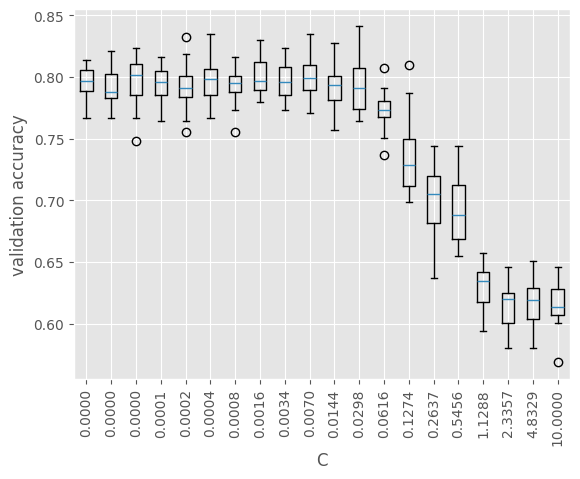

In [48]:
# now show a boxplot of the data across c
from matplotlib import pyplot as plt
%matplotlib inline

plt.boxplot(accs)
plt.xticks(range(1,len(costs)+1),['%.4f'%(c) for c in costs],rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()


___
# Next Time: Neural Networks
___

In this notebook you learned:
- Formulation of Logistic regression with different optimization strategies
 - Line Search
 - Mini-batch and Stochastic Gradient
- Newton's Approach using Hessian 
- Quasi Newton Method, BFGS
- Use Exhaustive Searches for Finding "C" 
- And Training/Testing Splits